# Semantic Embedding

## Get food.com dataset

In [1]:
!pip install kaggle

# Copy kaggle.json provided by kaggle to colab. Must have a kaggle account and request your API key.
!mkdir ~/.kaggle/
!mv kaggle.json ~/.kaggle/kaggle.json

import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('shuyangli94/food-com-recipes-and-user-interactions', path='./', unzip=False)

!unzip food-com-recipes-and-user-interactions.zip -d food-com-recipes-and-user-interactions

from pathlib import Path
import pandas as pd

raw_recipe_path = Path() / "food-com-recipes-and-user-interactions" / "RAW_recipes.csv"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Archive:  food-com-recipes-and-user-interactions.zip
  inflating: food-com-recipes-and-user-interactions/PP_recipes.csv  
  inflating: food-com-recipes-and-user-interactions/PP_users.csv  
  inflating: food-com-recipes-and-user-interactions/RAW_interactions.csv  
  inflating: food-com-recipes-and-user-interactions/RAW_recipes.csv  
  inflating: food-com-recipes-and-user-interactions/ingr_map.pkl  
  inflating: food-com-recipes-and-user-interactions/interactions_test.csv  
  inflating: food-com-recipes-and-user-interactions/interactions_train.csv  
  inflating: food-com-recipes-and-user-interactions/interactions_validation.csv  


In [2]:
import json

def save_foodcom_json(raw_recipe: pd.DataFrame, path: Path) -> dict:
    info_json = {}

    for i, row in raw_recipe[["name", "ingredients", "steps"]].iterrows():
        recipe = row["name"]
        ingredients = eval(row["ingredients"])
        instructions = eval(row["steps"])
        info_json[recipe] = {
            "nombre": recipe,
            "ingredientes": [{"nombre": ingredient, } for ingredient in ingredients],
            "instrucciones": [ {"orden": i, "instruccion": instruction, } for i, instruction in enumerate(instructions)],
        }

    json.dump(info_json, path.open("+w"))
    return info_json


raw_csv = pd.read_csv(raw_recipe_path)
foodcom_json = save_foodcom_json(raw_csv, Path("foodcom.json"))

In [ ]:
import json
from pathlib import Path

foodcom_json_path = Path("foodcom.json")
foodcom_json = json.load(foodcom_json_path.open())

# Recipe embedding

## Using Universal Sentence Encoder

From [this](https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder) source

In [ ]:
%%capture
!pip3 install seaborn

In [3]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [0.008344486355781555, 0.00048085825983434916, 0.06595248728990555, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.050808604806661606, -0.016524329781532288, 0.01573779620230198, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.028332693502306938, -0.0558621808886528, -0.012941480614244938, ...]



In [4]:
recipe_json = foodcom_json

def get_recipe_text(json):
  new_json = {}
  for recipe in json:
    new_json[recipe] = {
        "ingredients": [x["nombre"] for x in json[recipe]["ingredientes"]],
        "steps": [x["instruccion"] for x in json[recipe]["instrucciones"]]
    }
  return new_json

new_recipe_json = get_recipe_text(recipe_json)
del recipe_json
del foodcom_json

In [ ]:
df = pd.DataFrame({
    "recipe": list(new_recipe_json),
    "steps": [len(x["steps"]) for x in new_recipe_json.values()],
    "ingredients": [len(x["ingredients"]) for x in new_recipe_json.values()],
  })

,steps,ingredients
count,230186.000000,230186.000000
mean,9.768466,9.051654
std,5.996906,3.737725
min,0.000000,1.000000
25%,6.000000,6.000000
50%,9.000000,9.000000
75%,12.000000,11.000000
max,145.000000,43.000000


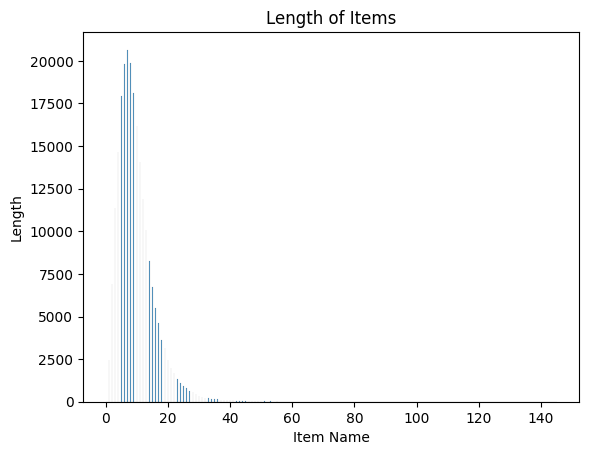

In [ ]:

import seaborn as sns

display(df.describe())

# Create a bar plot of the length column using Seaborn
sns.histplot(x='steps', data=df)

# Add a title and axis labels
plt.title('Length of Items')
plt.xlabel('Item Name')
plt.ylabel('Length')

# Show the plot
plt.show()

In [ ]:
def get_steps_string(recipe_info):
  return "\n".join(f"{i}. {step}" for i, step in enumerate(recipe_info["steps"]))

def get_ingredients_string(recipe_info):
  return "\n".join(f"{i}. {step}" for i, step in enumerate(recipe_info["ingredients"]))


In [5]:
from sklearn.model_selection import train_test_split

train, test_and_val = train_test_split([x for x in new_recipe_json], test_size=0.4, random_state=42)
test, val = train_test_split(test_and_val, test_size=0.25, random_state=46)

# print the length of each set
print("Train set length:", len(train))
print("Validation set length:", len(val))
print("Test set length:", len(test))
print("All length:", len(train + val + test))

Train set length: 138111
Validation set length: 23019
Test set length: 69056
All length: 230186


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow.keras.layers as layers
import tensorflow as tf
from math import ceil

max_seq_length = 256


def get_vector(text):
  try:
    vector = embed(text)
  except:
    print(f"FAILED: {text}")
    vector = tf.zeros(shape=(max_seq_length,512))
  add_to_shape = max_seq_length - tf.shape(vector)[0]
  vector = tf.concat([vector, tf.zeros(shape=(add_to_shape,512))], axis=0)
  return vector

def get_dataset_from_string(string_list):
  data = None
  for string in string_list:
    vector = get_vector(string)
    vector = tf.reshape(vector, shape=(1, max_seq_length, 512))
    if data is None:
      data = vector
    else:
      data = tf.concat([data, vector], axis=0)

  ds = tf.data.Dataset.from_tensor_slices(data)
  return tf.data.Dataset.zip((ds, ds))

def save_dataset(recipe_list: list[str], split: str, initial_batch=0):
  batch_size = 2048
  print(len(recipe_list))
  print(ceil(len(recipe_list) / batch_size))
  for batch in range(initial_batch, ceil(len(recipe_list) / batch_size)):
    print(f"Start {batch}")
    print((batch*batch_size,batch_size*(batch + 1)))
    print(len(recipe_list[batch*batch_size:(batch + 1)*batch_size]))
    dataset = get_dataset_from_string([new_recipe_json[x]["steps"] for x in recipe_list[batch*batch_size:(batch + 1)*batch_size]])
    dataset.save(f"/content/drive/MyDrive/{batch:0>5}_{split}.ds", compression="GZIP")
    print(f"End {batch}")

# save_dataset(train, "train", initial_batch=0)
# save_dataset(val, "val", initial_batch=0)
# save_dataset(test, "test", initial_batch=0)


23019
12
Start 11
(22528, 24576)
491
End 11
69056
34
Start 33
(67584, 69632)
1472
End 33


In [ ]:
from pathlib import Path
import tensorflow as tf

def process_ds(split: str):
  base_path = Path("/content/drive/MyDrive")
  ds = None
  for file in sorted([x for x in base_path.iterdir()]):
    if file.is_dir() and file.name.split("_")[-1].startswith(split) and file.name.endswith(".ds"):
      current_ds = tf.data.Dataset.load(str(file), compression="GZIP")
      if ds is None:
        ds = current_ds
      else:
        ds = ds.concatenate(current_ds)
  return ds

train_ds = process_ds("train")
dev_ds = process_ds("val")
test_ds = process_ds("test")


In [ ]:
import tensorflow.keras.layers as layers
import tensorflow as tf
max_seq_length = 256

def encode():
  input = model = layers.Input(shape=(max_seq_length, 512))
  model = layers.Conv1D(256, 2)(model)
  model = layers.MaxPooling1D(2)(model)
  model = layers.Conv1D(128, 2)(model)
  model = layers.MaxPooling1D(2)(model)
  model = layers.Conv1D(64, 2)(model)
  model = layers.MaxPooling1D(2)(model)
  model = layers.Conv1D(32, 2)(model)
  model = layers.Reshape((30 * 32,))(model)
  model = layers.Dense(512)(model)
  model = layers.Dense(256)(model)
  model = tf.keras.Model(inputs=input, outputs=model)
  return model

def decode():
  decoder_input = decoder_output = layers.Input(shape=(256,))
  decoder_output = layers.Dense(512)(decoder_output)
  decoder_output = layers.Dense(30 * 32)(decoder_output)
  decoder_output = layers.Reshape((30, 32))(decoder_output)
  decoder_output = layers.Conv1DTranspose(64, 2)(decoder_output)
  decoder_output = layers.Conv1DTranspose(64, 2, strides=2)(decoder_output)
  decoder_output = layers.Conv1DTranspose(128, 2)(decoder_output)
  decoder_output = layers.Conv1DTranspose(128, 2, strides=2)(decoder_output)
  decoder_output = layers.Conv1DTranspose(256, 2)(decoder_output)
  decoder_output = layers.Conv1DTranspose(256, 2, strides=2)(decoder_output)
  decoder_output = layers.Conv1DTranspose(512, 3)(decoder_output)
  decoder = tf.keras.Model(inputs=decoder_input, outputs=decoder_output)
  return decoder

def encoder_att():
  input = model = layers.Input(shape=(max_seq_length, 512))
  model = layers.Conv1D(256, 3, strides=2, padding='same')(model)
  model = layers.Attention()([model, model])
  model = layers.MaxPooling1D(2)(model)
  model = layers.Conv1D(128, 3, strides=2, padding='same')(model)
  model = layers.Attention()([model, model])
  model = layers.Conv1D(64, 3, strides=2, padding='same')(model)
  model = layers.Attention()([model, model])
  model = layers.AveragePooling1D(2)(model)
  model = layers.Reshape((512,))(model)
  model = layers.Dense(256)(model)
  model = tf.keras.Model(inputs=input, outputs=model, name="encoder_attr")
  return model

def decoder_att():
  input = model = layers.Input(shape=(256,))
  model = layers.Dense(512)(model)
  model = layers.Reshape((8, 64))(model)
  model = layers.Conv1DTranspose(64, 3, strides=2, padding='same')(model)
  model = layers.Conv1DTranspose(64, 3, strides=2, padding='same')(model)
  model = layers.Attention()([model, model])
  model = layers.Conv1DTranspose(128, 3, strides=2, padding='same')(model)
  model = layers.Attention()([model, model])
  model = layers.Conv1DTranspose(256, 3, strides=2, padding='same')(model)
  model = layers.Attention()([model, model])
  model = layers.Conv1DTranspose(512, 3, strides=2, padding='same')(model)
  model = layers.Attention()([model, model])
  model = tf.keras.Model(inputs=input, outputs=model, name="decoder_attr")
  return model


# e1 = encode()
# d1 = decode()
# input = layers.Input(shape=(max_seq_length, 512))
# final = d1(e1(input))
# model = tf.keras.Model(inputs=input, outputs=final)
# model.summary()

e2 = encoder_att()
d2 = decoder_att()
# input = layers.Input(shape=(max_seq_length, 512))
# final = d2(e2(input))
# model = tf.keras.Model(inputs=input, outputs=final)
# model.summary()

encoder = e2
decoder = d2


In [ ]:
import tensorflow.keras as keras
import numpy as np
class SaveModelCallback(keras.callbacks.Callback):

  def __init__(self, model, path):
    self.model = model
    self.path = path

  def on_epoch_end(self, epoch, logs=None):
    print()
    print("Saved model epoch", epoch, "at", self.path)
    self.model.save(self.path)


In [ ]:
import tensorflow.keras.layers as layers
max_seq_length = 256

batch_size = 128
def train(ds, encoder, decoder, val=None, epochs=40):
  input = layers.Input(shape=(max_seq_length, 512), name="model_input")
  encoder_output = encoder(input)
  final = decoder(encoder_output)
  model = tf.keras.Model(inputs=input, outputs=[encoder_output, final], name="full_encoder_decoder")

  checkpoint_filepath = '/content/drive/MyDrive/checkpoint'

  model_early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

  encoder_save_callback = SaveModelCallback(encoder, '/content/drive/MyDrive/encoder.tf')
  # decoder_save_callback = SaveModelCallback(decoder, '/content/drive/MyDrive/decoder.tf')
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/model.tf', save_weights_only=False, verbose=1)
  cp_callback_weight = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/model_weights/model.weights', save_weights_only=True, verbose=1)

  callbacks = [
      cp_callback,
      cp_callback_weight,
      model_early_stopping_callback,
      encoder_save_callback,
      # decoder_save_callback,
    ]

  model.compile(optimizer='sgd', loss='mse', loss_weights=[0, 1]) # Faster
  # model.compile(optimizer='adam', loss='mse', loss_weights=[0, 1])
  model.summary()
  ds = ds.map(lambda x,y: (x, (tf.zeros(shape=(256,)), y)))
  if val is None:
    process = model.fit(ds.batch(batch_size), batch_size=batch_size, epochs=epochs, callbacks=callbacks)
  else:
    val = val.map(lambda x,y: (x, (tf.zeros(shape=(256,)), y)))
    process = model.fit(ds.batch(batch_size), batch_size=batch_size, epochs=epochs, validation_data=val.batch(batch_size), callbacks=callbacks)
  return model, process

ds_window = 0
ds_window_size = 128000
ds_val_window_size = ds_window_size // 10
print("Current:", ds_window)
print("Total", len(train_ds) / ds_window_size)

trained_model, process = train(train_ds.skip(ds_window * ds_window_size).take((ds_window + 1) * ds_window_size), encoder, decoder, dev_ds.skip(ds_window * ds_val_window_size).take((ds_window + 1) * ds_val_window_size))


Current: 0
Total 1.0069921875
Model: "full_encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 256, 512)]        0         
                                                                 
 encoder_attr (Functional)   (None, 256)               647872    
                                                                 
 decoder_attr (Functional)   (None, 256, 512)          673280    
                                                                 
Total params: 1,321,152
Trainable params: 1,321,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4538e-05 - encoder_attr_loss: 3.5448e-06 - decoder_attr_loss: 7.4538e-05
Epoch 1: saving model to /content/drive/MyDrive/model.tf



Epoch 1: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 0 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 476s 472ms/step - loss: 7.4538e-05 - encoder_attr_loss: 3.5448e-06 - decoder_attr_loss: 7.4538e-05 - val_loss: 7.4247e-05 - val_encoder_attr_loss: 3.5407e-06 - val_decoder_attr_loss: 7.4247e-05
Epoch 2/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4497e-05 - encoder_attr_loss: 3.5429e-06 - decoder_attr_loss: 7.4497e-05
Epoch 2: saving model to /content/drive/MyDrive/model.tf



Epoch 2: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 1 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 474s 474ms/step - loss: 7.4497e-05 - encoder_attr_loss: 3.5429e-06 - decoder_attr_loss: 7.4497e-05 - val_loss: 7.4208e-05 - val_encoder_attr_loss: 3.5389e-06 - val_decoder_attr_loss: 7.4208e-05
Epoch 3/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4459e-05 - encoder_attr_loss: 3.5411e-06 - decoder_attr_loss: 7.4459e-05
Epoch 3: saving model to /content/drive/MyDrive/model.tf



Epoch 3: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 2 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 475s 475ms/step - loss: 7.4459e-05 - encoder_attr_loss: 3.5411e-06 - decoder_attr_loss: 7.4459e-05 - val_loss: 7.4173e-05 - val_encoder_attr_loss: 3.5372e-06 - val_decoder_attr_loss: 7.4173e-05
Epoch 4/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4425e-05 - encoder_attr_loss: 3.5395e-06 - decoder_attr_loss: 7.4425e-05
Epoch 4: saving model to /content/drive/MyDrive/model.tf



Epoch 4: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 3 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 518s 518ms/step - loss: 7.4425e-05 - encoder_attr_loss: 3.5395e-06 - decoder_attr_loss: 7.4425e-05 - val_loss: 7.4141e-05 - val_encoder_attr_loss: 3.5356e-06 - val_decoder_attr_loss: 7.4141e-05
Epoch 5/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4395e-05 - encoder_attr_loss: 3.5379e-06 - decoder_attr_loss: 7.4395e-05
Epoch 5: saving model to /content/drive/MyDrive/model.tf



Epoch 5: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 4 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 475s 475ms/step - loss: 7.4395e-05 - encoder_attr_loss: 3.5379e-06 - decoder_attr_loss: 7.4395e-05 - val_loss: 7.4111e-05 - val_encoder_attr_loss: 3.5341e-06 - val_decoder_attr_loss: 7.4111e-05
Epoch 6/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4367e-05 - encoder_attr_loss: 3.5365e-06 - decoder_attr_loss: 7.4367e-05
Epoch 6: saving model to /content/drive/MyDrive/model.tf



Epoch 6: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 5 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 489s 489ms/step - loss: 7.4367e-05 - encoder_attr_loss: 3.5365e-06 - decoder_attr_loss: 7.4367e-05 - val_loss: 7.4085e-05 - val_encoder_attr_loss: 3.5327e-06 - val_decoder_attr_loss: 7.4085e-05
Epoch 7/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4342e-05 - encoder_attr_loss: 3.5351e-06 - decoder_attr_loss: 7.4342e-05
Epoch 7: saving model to /content/drive/MyDrive/model.tf



Epoch 7: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 6 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 524s 524ms/step - loss: 7.4342e-05 - encoder_attr_loss: 3.5351e-06 - decoder_attr_loss: 7.4342e-05 - val_loss: 7.4061e-05 - val_encoder_attr_loss: 3.5314e-06 - val_decoder_attr_loss: 7.4061e-05
Epoch 8/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4319e-05 - encoder_attr_loss: 3.5339e-06 - decoder_attr_loss: 7.4319e-05
Epoch 8: saving model to /content/drive/MyDrive/model.tf



Epoch 8: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 7 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 518s 518ms/step - loss: 7.4319e-05 - encoder_attr_loss: 3.5339e-06 - decoder_attr_loss: 7.4319e-05 - val_loss: 7.4039e-05 - val_encoder_attr_loss: 3.5302e-06 - val_decoder_attr_loss: 7.4039e-05
Epoch 9/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4298e-05 - encoder_attr_loss: 3.5327e-06 - decoder_attr_loss: 7.4298e-05
Epoch 9: saving model to /content/drive/MyDrive/model.tf



Epoch 9: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 8 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 475s 475ms/step - loss: 7.4298e-05 - encoder_attr_loss: 3.5327e-06 - decoder_attr_loss: 7.4298e-05 - val_loss: 7.4019e-05 - val_encoder_attr_loss: 3.5291e-06 - val_decoder_attr_loss: 7.4019e-05
Epoch 10/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4279e-05 - encoder_attr_loss: 3.5316e-06 - decoder_attr_loss: 7.4279e-05
Epoch 10: saving model to /content/drive/MyDrive/model.tf



Epoch 10: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 9 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 473s 473ms/step - loss: 7.4279e-05 - encoder_attr_loss: 3.5316e-06 - decoder_attr_loss: 7.4279e-05 - val_loss: 7.4001e-05 - val_encoder_attr_loss: 3.5280e-06 - val_decoder_attr_loss: 7.4001e-05
Epoch 11/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4261e-05 - encoder_attr_loss: 3.5306e-06 - decoder_attr_loss: 7.4261e-05
Epoch 11: saving model to /content/drive/MyDrive/model.tf



Epoch 11: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 10 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 471s 470ms/step - loss: 7.4261e-05 - encoder_attr_loss: 3.5306e-06 - decoder_attr_loss: 7.4261e-05 - val_loss: 7.3985e-05 - val_encoder_attr_loss: 3.5271e-06 - val_decoder_attr_loss: 7.3985e-05
Epoch 12/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4245e-05 - encoder_attr_loss: 3.5297e-06 - decoder_attr_loss: 7.4245e-05
Epoch 12: saving model to /content/drive/MyDrive/model.tf



Epoch 12: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 11 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 471s 471ms/step - loss: 7.4245e-05 - encoder_attr_loss: 3.5297e-06 - decoder_attr_loss: 7.4245e-05 - val_loss: 7.3970e-05 - val_encoder_attr_loss: 3.5262e-06 - val_decoder_attr_loss: 7.3970e-05
Epoch 13/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4231e-05 - encoder_attr_loss: 3.5288e-06 - decoder_attr_loss: 7.4231e-05
Epoch 13: saving model to /content/drive/MyDrive/model.tf



Epoch 13: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 12 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 475s 475ms/step - loss: 7.4231e-05 - encoder_attr_loss: 3.5288e-06 - decoder_attr_loss: 7.4231e-05 - val_loss: 7.3956e-05 - val_encoder_attr_loss: 3.5253e-06 - val_decoder_attr_loss: 7.3956e-05
Epoch 14/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4218e-05 - encoder_attr_loss: 3.5280e-06 - decoder_attr_loss: 7.4218e-05
Epoch 14: saving model to /content/drive/MyDrive/model.tf



Epoch 14: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 13 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 517s 517ms/step - loss: 7.4218e-05 - encoder_attr_loss: 3.5280e-06 - decoder_attr_loss: 7.4218e-05 - val_loss: 7.3943e-05 - val_encoder_attr_loss: 3.5245e-06 - val_decoder_attr_loss: 7.3943e-05
Epoch 15/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4206e-05 - encoder_attr_loss: 3.5272e-06 - decoder_attr_loss: 7.4206e-05
Epoch 15: saving model to /content/drive/MyDrive/model.tf



Epoch 15: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 14 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 474s 474ms/step - loss: 7.4206e-05 - encoder_attr_loss: 3.5272e-06 - decoder_attr_loss: 7.4206e-05 - val_loss: 7.3932e-05 - val_encoder_attr_loss: 3.5238e-06 - val_decoder_attr_loss: 7.3932e-05
Epoch 16/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4195e-05 - encoder_attr_loss: 3.5265e-06 - decoder_attr_loss: 7.4195e-05
Epoch 16: saving model to /content/drive/MyDrive/model.tf



Epoch 16: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 15 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 514s 514ms/step - loss: 7.4195e-05 - encoder_attr_loss: 3.5265e-06 - decoder_attr_loss: 7.4195e-05 - val_loss: 7.3922e-05 - val_encoder_attr_loss: 3.5231e-06 - val_decoder_attr_loss: 7.3922e-05
Epoch 17/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4185e-05 - encoder_attr_loss: 3.5258e-06 - decoder_attr_loss: 7.4185e-05
Epoch 17: saving model to /content/drive/MyDrive/model.tf



Epoch 17: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 16 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 476s 476ms/step - loss: 7.4185e-05 - encoder_attr_loss: 3.5258e-06 - decoder_attr_loss: 7.4185e-05 - val_loss: 7.3912e-05 - val_encoder_attr_loss: 3.5225e-06 - val_decoder_attr_loss: 7.3912e-05
Epoch 18/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4176e-05 - encoder_attr_loss: 3.5252e-06 - decoder_attr_loss: 7.4176e-05
Epoch 18: saving model to /content/drive/MyDrive/model.tf



Epoch 18: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 17 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 475s 475ms/step - loss: 7.4176e-05 - encoder_attr_loss: 3.5252e-06 - decoder_attr_loss: 7.4176e-05 - val_loss: 7.3903e-05 - val_encoder_attr_loss: 3.5219e-06 - val_decoder_attr_loss: 7.3903e-05
Epoch 19/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4167e-05 - encoder_attr_loss: 3.5246e-06 - decoder_attr_loss: 7.4167e-05
Epoch 19: saving model to /content/drive/MyDrive/model.tf



Epoch 19: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 18 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 473s 473ms/step - loss: 7.4167e-05 - encoder_attr_loss: 3.5246e-06 - decoder_attr_loss: 7.4167e-05 - val_loss: 7.3895e-05 - val_encoder_attr_loss: 3.5213e-06 - val_decoder_attr_loss: 7.3895e-05
Epoch 20/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4160e-05 - encoder_attr_loss: 3.5241e-06 - decoder_attr_loss: 7.4160e-05
Epoch 20: saving model to /content/drive/MyDrive/model.tf



Epoch 20: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 19 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 475s 475ms/step - loss: 7.4160e-05 - encoder_attr_loss: 3.5241e-06 - decoder_attr_loss: 7.4160e-05 - val_loss: 7.3888e-05 - val_encoder_attr_loss: 3.5208e-06 - val_decoder_attr_loss: 7.3888e-05
Epoch 21/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4153e-05 - encoder_attr_loss: 3.5236e-06 - decoder_attr_loss: 7.4153e-05
Epoch 21: saving model to /content/drive/MyDrive/model.tf



Epoch 21: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 20 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 473s 473ms/step - loss: 7.4153e-05 - encoder_attr_loss: 3.5236e-06 - decoder_attr_loss: 7.4153e-05 - val_loss: 7.3881e-05 - val_encoder_attr_loss: 3.5203e-06 - val_decoder_attr_loss: 7.3881e-05
Epoch 22/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4146e-05 - encoder_attr_loss: 3.5231e-06 - decoder_attr_loss: 7.4146e-05
Epoch 22: saving model to /content/drive/MyDrive/model.tf



Epoch 22: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 21 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 471s 471ms/step - loss: 7.4146e-05 - encoder_attr_loss: 3.5231e-06 - decoder_attr_loss: 7.4146e-05 - val_loss: 7.3875e-05 - val_encoder_attr_loss: 3.5198e-06 - val_decoder_attr_loss: 7.3875e-05
Epoch 23/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4140e-05 - encoder_attr_loss: 3.5227e-06 - decoder_attr_loss: 7.4140e-05
Epoch 23: saving model to /content/drive/MyDrive/model.tf



Epoch 23: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 22 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 469s 469ms/step - loss: 7.4140e-05 - encoder_attr_loss: 3.5227e-06 - decoder_attr_loss: 7.4140e-05 - val_loss: 7.3870e-05 - val_encoder_attr_loss: 3.5194e-06 - val_decoder_attr_loss: 7.3870e-05
Epoch 24/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4135e-05 - encoder_attr_loss: 3.5223e-06 - decoder_attr_loss: 7.4135e-05
Epoch 24: saving model to /content/drive/MyDrive/model.tf



Epoch 24: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 23 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 476s 476ms/step - loss: 7.4135e-05 - encoder_attr_loss: 3.5223e-06 - decoder_attr_loss: 7.4135e-05 - val_loss: 7.3865e-05 - val_encoder_attr_loss: 3.5190e-06 - val_decoder_attr_loss: 7.3865e-05
Epoch 25/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4130e-05 - encoder_attr_loss: 3.5219e-06 - decoder_attr_loss: 7.4130e-05
Epoch 25: saving model to /content/drive/MyDrive/model.tf



Epoch 25: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 24 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 486s 486ms/step - loss: 7.4130e-05 - encoder_attr_loss: 3.5219e-06 - decoder_attr_loss: 7.4130e-05 - val_loss: 7.3860e-05 - val_encoder_attr_loss: 3.5186e-06 - val_decoder_attr_loss: 7.3860e-05
Epoch 26/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4125e-05 - encoder_attr_loss: 3.5215e-06 - decoder_attr_loss: 7.4125e-05
Epoch 26: saving model to /content/drive/MyDrive/model.tf



Epoch 26: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 25 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 523s 523ms/step - loss: 7.4125e-05 - encoder_attr_loss: 3.5215e-06 - decoder_attr_loss: 7.4125e-05 - val_loss: 7.3856e-05 - val_encoder_attr_loss: 3.5183e-06 - val_decoder_attr_loss: 7.3856e-05
Epoch 27/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4121e-05 - encoder_attr_loss: 3.5211e-06 - decoder_attr_loss: 7.4121e-05
Epoch 27: saving model to /content/drive/MyDrive/model.tf



Epoch 27: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 26 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 520s 520ms/step - loss: 7.4121e-05 - encoder_attr_loss: 3.5211e-06 - decoder_attr_loss: 7.4121e-05 - val_loss: 7.3852e-05 - val_encoder_attr_loss: 3.5179e-06 - val_decoder_attr_loss: 7.3852e-05
Epoch 28/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4117e-05 - encoder_attr_loss: 3.5208e-06 - decoder_attr_loss: 7.4117e-05
Epoch 28: saving model to /content/drive/MyDrive/model.tf



Epoch 28: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 27 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 475s 475ms/step - loss: 7.4117e-05 - encoder_attr_loss: 3.5208e-06 - decoder_attr_loss: 7.4117e-05 - val_loss: 7.3848e-05 - val_encoder_attr_loss: 3.5176e-06 - val_decoder_attr_loss: 7.3848e-05
Epoch 29/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4114e-05 - encoder_attr_loss: 3.5205e-06 - decoder_attr_loss: 7.4114e-05
Epoch 29: saving model to /content/drive/MyDrive/model.tf



Epoch 29: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 28 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 516s 516ms/step - loss: 7.4114e-05 - encoder_attr_loss: 3.5205e-06 - decoder_attr_loss: 7.4114e-05 - val_loss: 7.3845e-05 - val_encoder_attr_loss: 3.5173e-06 - val_decoder_attr_loss: 7.3845e-05
Epoch 30/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4111e-05 - encoder_attr_loss: 3.5202e-06 - decoder_attr_loss: 7.4111e-05
Epoch 30: saving model to /content/drive/MyDrive/model.tf



Epoch 30: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 29 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 518s 518ms/step - loss: 7.4111e-05 - encoder_attr_loss: 3.5202e-06 - decoder_attr_loss: 7.4111e-05 - val_loss: 7.3842e-05 - val_encoder_attr_loss: 3.5171e-06 - val_decoder_attr_loss: 7.3842e-05
Epoch 31/40
1000/1000 [==============================] - ETA: 0s - loss: 7.4108e-05 - encoder_attr_loss: 3.5200e-06 - decoder_attr_loss: 7.4108e-05
Epoch 31: saving model to /content/drive/MyDrive/model.tf



Epoch 31: saving model to /content/drive/MyDrive/model_weights/model.weights

Saved model epoch 30 at /content/drive/MyDrive/encoder.tf


1000/1000 [==============================] - 521s 521ms/step - loss: 7.4108e-05 - encoder_attr_loss: 3.5200e-06 - decoder_attr_loss: 7.4108e-05 - val_loss: 7.3839e-05 - val_encoder_attr_loss: 3.5168e-06 - val_decoder_attr_loss: 7.3839e-05
Epoch 32/40
 781/1000 [======================>.......] - ETA: 1:34 - loss: 7.4071e-05 - encoder_attr_loss: 3.5096e-06 - decoder_attr_loss: 7.4071e-05

loss
val_loss


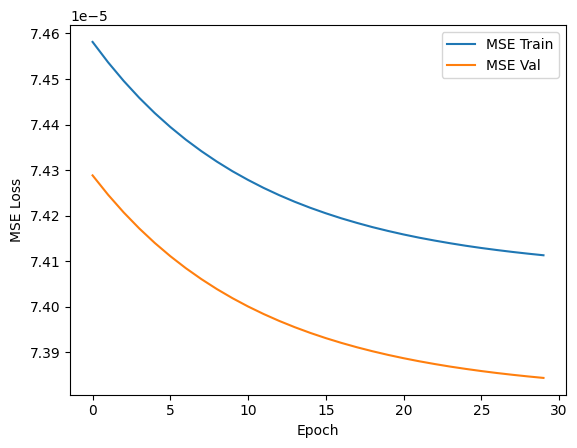

In [ ]:
for x in process.history:
  print(x)
import json

json.dump(process.history, open('/content/drive/MyDrive/training_history.json', mode="w"))

import matplotlib.pyplot as plt
X = [i for i in range(len(process.history['loss']))]
plt.plot(X, process.history['loss'], label="MSE Train")
plt.plot(X, process.history['val_loss'], label="MSE Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [6]:
import tensorflow as tf
# full_model = tf.keras.models.load_model('/content/drive/MyDrive/model.tf')
encoder = tf.keras.models.load_model('/content/drive/MyDrive/encoder.tf')
# decoder = tf.keras.models.load_model('/content/drive/MyDrive/decoder.tf')

In [ ]:
import numpy as np
from math import ceil

max_seq_length = 256

def get_recipe_vector(steps):
  try:
    vector = embed(steps)
  except:
    print(f"FAILED: {steps}")
    vector = tf.zeros(shape=(max_seq_length,512))
  add_to_shape = max_seq_length - tf.shape(vector)[0]
  vector = tf.concat([vector, tf.zeros(shape=(add_to_shape, 512))], axis=0)
  return vector

def save_dataset(recipe_list: list[str], encoder, full_model=None, initial_batch=0):
  batch_size = 2048
  batch_range = 100000
  print(len(recipe_list))
  print(ceil(len(recipe_list) / batch_size))

  for batch in range(initial_batch, min(ceil(len(recipe_list) / batch_size), initial_batch + batch_range)):
    repr = {}
    current_recipe_batch = recipe_list[batch * batch_size:(batch + 1) * batch_size]

    print(f"Start {batch}")
    print((batch*batch_size, batch_size * (batch + 1)))
    print(len(current_recipe_batch))

    for recipe in current_recipe_batch:
      steps = new_recipe_json[recipe]["steps"]
      vector = get_recipe_vector(steps)
      encoded = encoder(tf.reshape(vector, (1, 256, 512)))
      if full_model:
        encoded2 = full_model(tf.reshape(vector, (1, 256, 512)))
        print(all(encoded2[0][0] == encoded[0][0]))
      if not isinstance(recipe, str):
        continue
      repr[recipe] = np.array(encoded[0][0])
    print(f"End {batch}")

    np.savez_compressed(f"/content/drive/MyDrive/vector_repr_{batch}.json", **repr)

save_dataset(train + val + test, encoder, initial_batch=0)

In [ ]:
files = " ".join([f"/content/drive/MyDrive/vector_repr_{i}.json.npz" for i in range(114)])
!zip -r /content/drive/MyDrive/foodcom.sematic.zip $files